In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import random
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import operator
pd.set_option('mode.chained_assignment', None)

In [2]:
%matplotlib inline

In [3]:
#Create the dataframe we are going to use
df = pd.read_csv("/Users/JustinHolmes/Desktop/Staple Health/County/Mental Health Data/Concatenated_Data/US_County_All_Data_71019.csv", skiprows = 0, sep = ',', header = 0, dtype = {'FIPS': 'Int32'})
#Change any values to get better-looking results
#df['Household Income'] = df['Household Income'].apply(lambda x: x*.001)

#Print the head of the dataframe to see if it imports correctly
#print(df.head())

In [4]:
#Set the independent variable using the column names
ind1 = '% with SNAP'

# '% with SNAP'
# 'Average Daily PM2.5 (Air Pollution)'
# 'Association Rate'
# 'Gini Index Estimate'
# '% Adult Obese'
# 'Teen Birth Rate'
# 'Life Expectancy'

In [5]:
#Set the control variables using the column names
ctl1 = '% Female'
ctl2 = '% Non-Hispanic White'
ctl3 = '% 65 and over'
ctl4 = 'Household Income (In tens of thousands)'
ctl5 = 'Percent Educated'

In [6]:
#Set the dependent variable using the column name
dep1 = 'Mentally Unhealthy Days'

In [7]:
#Following variables used for the regression analysis
#X = df[[ind1, ind2, ind3, ind4, ind5]].iloc[0:100]
X = df[[ind1, ctl1, ctl2, ctl3, ctl4, ctl5]]
Y = df[dep1]
#sm.add_constant(X)

In [8]:
model = sm.OLS(Y, X, missing = 'drop')
results = model.fit()
print_model = results.summary()  
#print(print_model)

#### Plot to visualize relationship

In [9]:
#plot = sns.jointplot(x=df[ctl5], y=Y, data=df, kind = 'reg', joint_kws={'line_kws':{'color':'red'}})
#plot

### Before each time you run the function, initialize the list and dictionary, then run the cells to define the functions, then set the number of iterations you want, then run the cell that calls the functions

In [11]:
errorCounties = []
commonErrors = {}
avgError = {}

In [12]:
def train(iterations, daysOff):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=None)
    
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)

    coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  

    y_pred = regressor.predict(X_test)

    df1 = pd.DataFrame({'Predicted MH': y_pred, 'Actual MH': y_test})

    test = df1.join(df,how='left')

    df2 = test[["FIPS", "County_x", "State_x", "Gini Index Estimate", "Predicted MH", "Actual MH"]].copy()
    df2.rename(columns={'County_x':'County', "State_x":"State"}, inplace=True)

    
    ## Testing to see if there is a correlation between the Gini Index and Percent Error
    df3 = df2

    err = []
    for index, row in df2.iterrows():
        error = row['Predicted MH']-row['Actual MH']
        err.append(error)

    df3['Error (Days)'] = err

    #error_test = sns.jointplot(x="Gini Index Estimate", y="Error (Days)", data=df3, kind = 'reg', joint_kws={'line_kws':{'color':'red'}})
    #error_test

    
    ## Check which counties often are inaccurate
    for index, row in df3.iterrows():
        if abs(row[6]) > daysOff:
            errorCounties.append(row[0])
        if row[0] not in avgError:
            avgError[row[0]] = row[6]
        else:
            avgError[row[0]]+=(row[6])
        
    return df3

In [13]:
def getError(percentOff):    
    for ele in errorCounties:
        if ele not in commonErrors:
            commonErrors[ele] = 1
        else:
            commonErrors[ele] +=1
        
    df4 = df[['FIPS','County_x', 'State_x', "% Female", "% Non-Hispanic White", "% 65 and over", "Household Income (In tens of thousands)", "Percent Educated", 'Population_x', 'Gini Index Estimate', "Mentally Unhealthy Days"]].copy()
    df4.rename(columns={'County_x':'County', 'Population_x':'Population', "State_x":"State", "Household Income (In tens of thousands)":"Household Income"}, inplace=True)
    df4["Error"] = 0
    

    idx = 0
    for index, row in df4.iterrows():
        FIPS = row[0]
        if FIPS in errorCounties and errorCounties.count(FIPS) >= iterations/(100/percentOff):
            df4["Error"][idx] = 1
        idx += 1

    for index, row in df4.iterrows():
        if row[11] == 0:
            df4.drop(index, inplace=True)
    
    return df4

### Set desired iterations and error

In [16]:
iterations = 500
daysOff = 1
percentOff = 20
for i in range(iterations):
    df3 = train(iterations, daysOff)
    
df4 = getError(percentOff)

In [17]:
# sortedCommonErrors = sorted(commonErrors.items(), key=operator.itemgetter(1), reverse = True)
# for ele in sortedCommonErrors:
#     #Change number to set denominator for percent of trials that each county was an error (i.e. 2 means 25% of the time)
#     if ele[1] >= iterations/5:
#         print(ele)

In [18]:
for ele in commonErrors.items():
    ID=ele[0]
    count=ele[1]
    for index, row in df4.iterrows():
        if row[0] == ID:
            df4["Error"][index] = count/iterations*100
            break

In [19]:
df4.rename(columns={'Error':'% Error'}, inplace=True)
df4["Average Error"] = 0.0

In [20]:
for index, row in df4.iterrows():
    ID = row[0]
    df4["Average Error"][index] = avgError[ID]/iterations

### The following counties are incorrect by more than daysOff (1) days, at least percentOff (20%) of the time:

In [21]:
print("There are", len(df4), "counties that often have errors while testing for: ", ind1)

There are 56 counties that often have errors while testing for:  % with SNAP


In [22]:
df4.head()

,FIPS,County,State,% Female,% Non-Hispanic White,% 65 and over,Household Income,Percent Educated,Population,Gini Index Estimate,Mentally Unhealthy Days,% Error,Average Error
113,5005,Baxter,Arkansas,51.7,94.8,30.8,43.011,87.318772,41355,44.50,5.1,39,-0.489672
117,5013,Calhoun,Arkansas,49.9,72.1,21.1,42.484,84.162409,5247,44.05,5.0,41,-0.481281
136,5051,Garland,Arkansas,51.9,82.1,23.7,44.662,88.203727,98658,48.87,5.0,33,-0.400945
154,5087,Madison,Arkansas,50.0,89.6,18.8,40.568,79.640828,16339,46.26,5.1,36,-0.390866
160,5099,Nevada,Arkansas,50.3,62.6,20.4,46.687,85.755764,8327,40.77,5.3,37,-0.388876


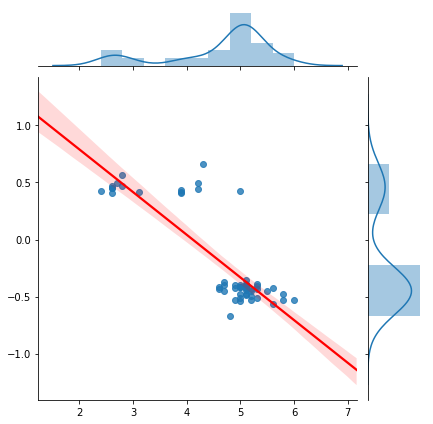

In [23]:
plot = sns.jointplot(x=["Mentally Unhealthy Days"], y=["Average Error"], data=df4, kind = 'reg', joint_kws={'line_kws':{'color':'red'}})
plot

